# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Sampling Functions

## Defining Constants

In [2]:
## Parameters for Two Well 1-D Potential

epsilon_0 = 5
epsilon_1 = 3
epsilon_2 = 4
sigma = 0.6

## Parameters for Hookian Restraint Potential
k = 2000

## Defining Landscape Potential Functions

Define Two-Well 1D Potential Function

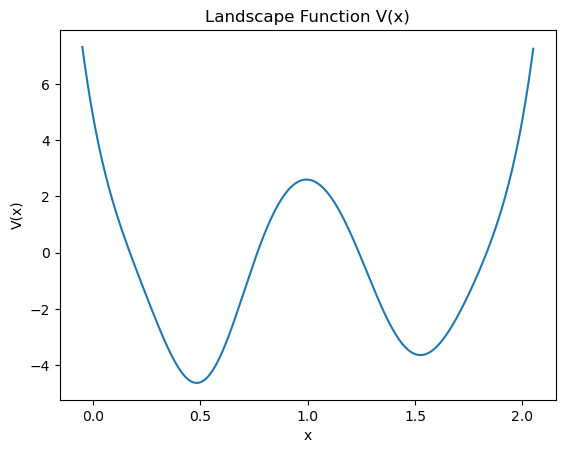

In [3]:
def two_well_1d(x, epsilon_0, epsilon_1, epsilon_2, sigma):
    """
    Defines the landscape function V(x) as described in the image.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_0 (float): Parameter epsilon_0.
    epsilon_1 (float): Parameter epsilon_1.
    epsilon_2 (float): Parameter epsilon_2.
    sigma (float): Parameter sigma.

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """

    term1 = 5 * (x - 1)**8
    term2 = epsilon_0 * np.exp((-epsilon_0 * (x - 0.5)**2) / sigma**2)
    term3 = epsilon_1 * np.exp((-epsilon_1 * (x - 1.0)**2) / sigma**2)
    term4 = epsilon_2 * np.exp((-epsilon_2 * (x - 1.5)**2) / sigma**2)

    return term1 - term2 + term3 - term4

def plot_landscape_fxn(V: callable):
    """
    Plots the landscape function V(x) as described in the image.
    """

    x = np.linspace(-0.05, 2.05, 1000)
    y = V(x, epsilon_0, epsilon_1, epsilon_2, sigma)

    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title('Landscape Function V(x)')
    plt.show()

plot_landscape_fxn(two_well_1d)

Define Multi-Well 1D Potential Function

In [4]:
def multi_well_potential(x, epsilon_0, epsilon_1, epsilon_2, sigma, base_power=8):
    """
    Defines a multi-well potential function V(x) with adjustable number of wells.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_values (list): List of epsilon values for each well.
    well_positions (list): List of x-positions for each well.
    sigma (float): Parameter controlling the width of the wells.
    base_power (int): Power for the base polynomial term (default is 8).

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """
    
    well_positions = [0.25, 0.75, 1.5]
    epsilon_values = [epsilon_0, epsilon_1, epsilon_2]
    
    # Base polynomial term
    base_term = 5 * np.min([(x - pos)**base_power for pos in well_positions], axis=0)
    
    # Sum of Gaussian wells
    wells = sum(epsilon * np.exp((-epsilon * (x - pos)**2) / sigma**2) 
                for epsilon, pos in zip(epsilon_values, well_positions))
    
    return base_term - wells

## Defining Restoring Bias Functions

In [6]:
Nwindows = 100
min_x = -0.05
max_x = 2.05
dx = (max_x - min_x) / Nwindows

# range of x values
x = np.linspace(min_x, max_x, Nwindows)

# define bias functions for each window
bias: list[callable] = []

centers = np.linspace(min_x + dx/2, max_x - dx/2, Nwindows)

class PsiFunction:
    def __init__(self, center, k):
        self.center = center
        self.k = k

    def __call__(self, x):
        return 0.5 * self.k * (x - self.center)**2

def create_biases(centers, k):
    return [PsiFunction(center, k) for center in centers]

bias = create_biases(centers, k)

# for center in centers:
#     # Correct way to capture the value of 'center'
#     psi = lambda x, c=center: 0.5 * k * (x - c)**2  # harmonic potential
#     bias.append(psi)

### Plot Restoring Bias Functions

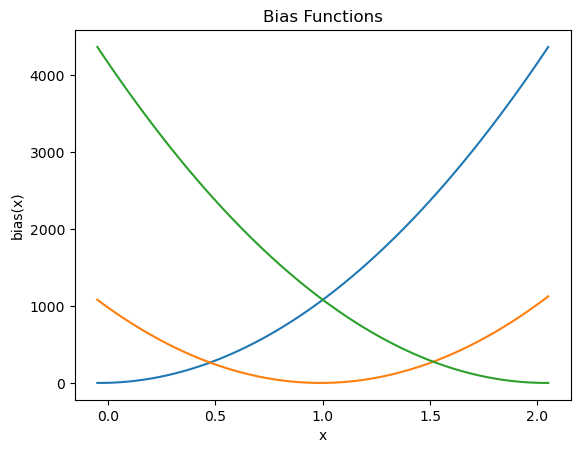

In [7]:
# plot the bias functions

# get the 1, 50, 99 bias functions
for psi in [bias[0], bias[49], bias[99]]:
    plt.plot(x, psi(x))
    
plt.xlabel('x')
plt.ylabel('bias(x)')
plt.title('Bias Functions')
plt.show()

# Monte-Carlo Sampling

Now, we actually implement the Monte-Carlo sampling algorithm to sample from the landscape potential function in the presence of a restoring bias function (which is essentially sampling from a window of the landscape potential function).

## Constants

In [8]:
T = 50 # K
kB = 1.38064852e-2 # Boltzmann constant (zJ/K)
beta = 1 / (kB * T)
printModulus = 10 # frequency of prints to screen
writeModulus = 10  # frequency of writes to file
dispSize = 0.05
nSweeps = 100000 # number of MC sweeps

## Helper Functions

## Monte-Carlo Sampling Algorithm

In [9]:
samples = np.zeros((Nwindows, nSweeps))

def monte_carlo_sampling_per_window(args):
    """
    Perform Monte Carlo sampling of the biased distribution for a given window.

    Args:
    window_index (int): The index of the window.
    biases (callable): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """

    # unpack the arguments
    window_index, biases, V = args

    # get the bias function for the window
    bias = biases[window_index]
    
    # define the range of x values for the window
    start_x = min_x + window_index * dx
    end_x = start_x + dx

    # pick a random starting point in the window and get potential energy
    current_x = np.random.uniform(start_x, end_x)
    current_U = V(current_x, epsilon_0, epsilon_1, epsilon_2, sigma) + bias(current_x)

    for sweep in range(nSweeps):
        # propose a new position
        proposed_x = current_x + dispSize * np.random.uniform(-1, 1)
        proposed_U = V(proposed_x, epsilon_0, epsilon_1, epsilon_2, sigma) + bias(proposed_x)

        # acceptance criterion
        delta_U = proposed_U - current_U
        acceptance_prob = min(0, -beta * delta_U)

        # accept or reject
        if np.log(np.random.uniform()) < acceptance_prob:
            current_x = proposed_x
            current_U = proposed_U

        samples[window_index, sweep] = current_x
        
        # print to screen and write to file
        # if sweep % printModulus == 0:
        #     print(f'Window {window_index}, Sweep {sweep}, x = {current_x:.3f}, U = {current_U:.3f}')
        #     print(f"Acceptance probability: {acceptance_prob}")

def monte_carlo_sampling(biases, V):
    """
    Perform Monte Carlo sampling of the biased distribution.

    Args:
    biases (list[callable]): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """
    for i in range(Nwindows):
        args = (i, biases, V)
        monte_carlo_sampling_per_window(args)

def parallel_monte_carlo_sampling(biases, V):
    """
    Perform Monte Carlo sampling of the biased distribution in parallel.

    Args:
    biases (list[callable]): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """
    pool = Pool()
    # create a list of arguments for the monte_carlo_sampling_per_window function
    args = [(i, biases, V) for i in range(Nwindows)]

    # perform the sampling in parallel
    pool.map(monte_carlo_sampling_per_window, args)
    pool.close()
    pool.join()

In [10]:
monte_carlo_sampling(bias, two_well_1d)

# dump the samples to a file
np.savetxt('samples.txt', samples)

# Sample Analysis

In [11]:
samples = np.loadtxt('samples.txt')
samples.shape

(100, 100000)

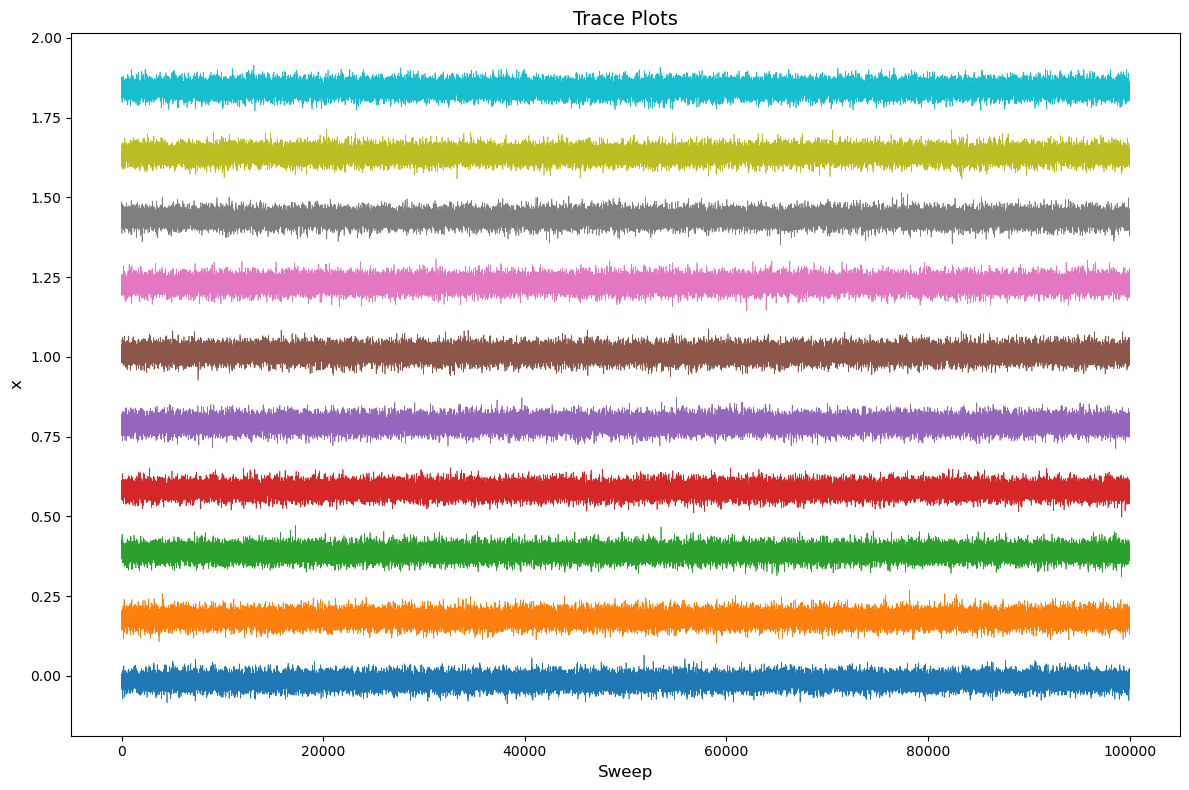

In [12]:
# Set the figure size to make the plot bigger
plt.figure(figsize=(12, 8))

# Plot the trace plots for all windows on the same plot
for i in range(Nwindows):
    if i % 10 == 0:
        plt.plot(samples[i, :], linewidth=0.5)  # Reduced linewidth for thinner lines

plt.xlabel('Sweep', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Trace Plots', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)  # Adjust tick label size if needed

plt.tight_layout()  # Adjust the layout to prevent clipping of labels
plt.show()


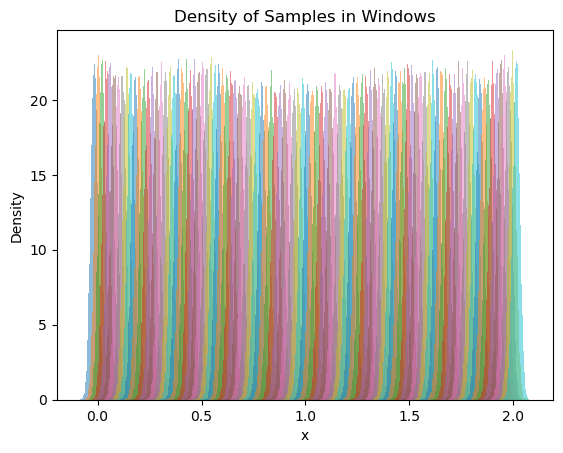

In [13]:
# plot densities of the samples in all the windows
for i in range(Nwindows):
    plt.hist(samples[i], bins=50, density=True, alpha=0.5)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density of Samples in Windows')
plt.show()

# WHAM

In [14]:
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_normalized(P, bin_centers, color, bin_width):
    P_AUC = np.sum(P) * bin_width
    P_normalized = P / P_AUC

    spline = UnivariateSpline(bin_centers, P_normalized, s=0.005)
    P_smooth = spline(bin_centers)

    plt.plot(bin_centers, P_smooth, '-', color=color)

def WHAM(samples, bias, plot=False, num_bins=100, max_iters=100, max_atol=1e-6):
    n = len(samples)

    bin_edges = np.linspace(min_x, max_x, num_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_width = bin_centers[-1] - bin_centers[-2]

    hists = [np.histogram(samples[i,:], bins=bin_edges)[0] for i in range(n)] # bin counts

    n_ks = [np.sum(hists[k]) for k in range(n)]

    # Gather the biased probabilities
    P_tilde = np.array([hist_k / (bin_width * n_k) for hist_k, n_k in zip(hists, n_ks)])

    # Initialize free energies and probability function
    A = np.zeros(n)
    P = np.zeros(num_bins)
    A_0 = 0

    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        cmap = cm.get_cmap('viridis', max_iters)

    for iter in range(max_iters):
        # Iteratively update P
        numerator = np.zeros(num_bins)
        denominator = np.zeros(num_bins)
        for k in range(n):
            numerator += P_tilde[k] * n_ks[k]

            denominator += n_ks[k] * np.exp(beta * (A[k] - A_0)) * np.exp(-beta * bias[k](bin_centers))
    
        P = numerator / denominator

        # Iteratively update the free energies
        max_free_energy_diff = 0

        for k in range(n):
            integral = bin_width * np.sum(P * np.exp(-beta * bias[k](bin_centers)))
            A_k_new = - np.log(integral) / beta + A_0
            
            max_free_energy_diff = max(max_free_energy_diff, abs(A_k_new - A[k]))
            A[k] = A_k_new
        
        # Normalize the probability distribution
        P /= np.sum(P) * bin_width

        if plot and iter % 5 == 0:
            color = cmap(iter / max_iters)  # Map iteration to a color in the colormap
            plot_normalized(P, bin_centers, color, bin_width)

        # Convergence criteria
        if max_free_energy_diff < max_atol:
            break

    if plot:
        norm = mcolors.Normalize(vmin=0, vmax=max_iters)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Set an empty array to avoid warnings about missing data

        cbar = fig.colorbar(sm, ax=ax)  # Associate the colorbar with the main axes
        cbar.set_label('Iteration')

        plt.xlabel('x')
        plt.ylabel('P')
        plt.title('Constructing the Probability Distribution')

        # plotting the true distribution
        recip_V = np.exp(-beta * two_well_1d(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma))
        bin_width = (bin_centers[-1] - bin_centers[-2])
        norm_recip_V = recip_V/(np.sum(recip_V) * bin_width)
        plt.plot(bin_centers, norm_recip_V, color="red", linewidth=5, label="True")
        plt.gca().set_aspect('auto')
        plt.tight_layout()

        plt.show()
    
    global_free_energy = -1/beta * np.log(P) + A_0
    
    return P, hists, bin_centers, bin_edges, global_free_energy

/var/folders/gf/rqrz_xpd00b34c0v2n9m1q1m0000gn/T/ipykernel_54447/2484225039.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_iters)


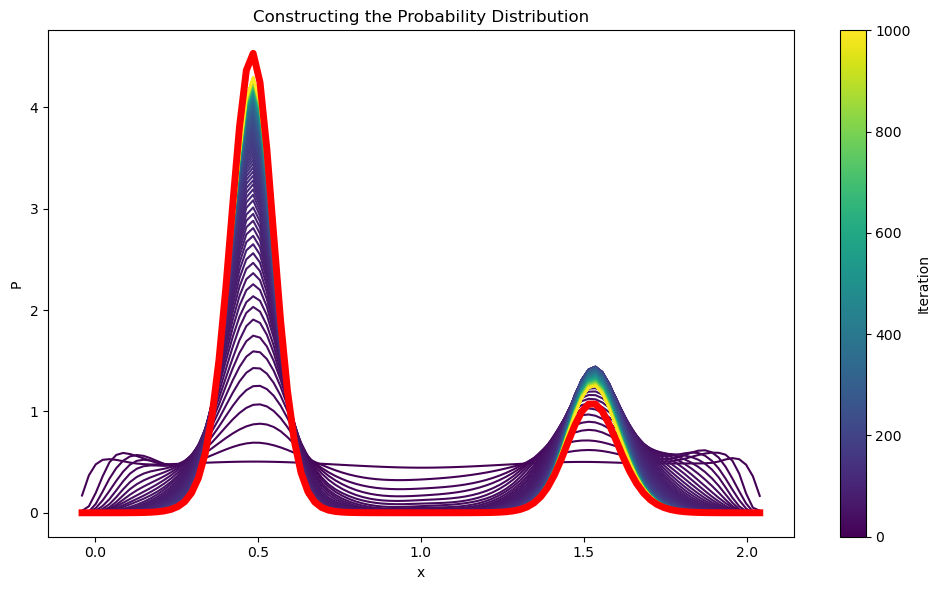

In [15]:
P, hists, bin_centers, bin_edges, global_free_energy = WHAM(samples, bias, plot=True, num_bins=100, max_iters=1000, max_atol=1e-6)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from PIL import Image
import io

def WHAM_gif(samples, bias, V, num_bins=100, max_iters=100, max_atol=1e-6, prefix=""):
    n = len(samples)
    bin_edges = np.linspace(min_x, max_x, num_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_width = bin_centers[-1] - bin_centers[-2]
    hists = [np.histogram(samples[i,:], bins=bin_edges)[0] for i in range(n)]
    n_ks = [np.sum(hists[k]) for k in range(n)]
    P_tilde = np.array([hist_k / (bin_width * n_k) for hist_k, n_k in zip(hists, n_ks)])
    A = np.zeros(n)
    P = np.zeros(num_bins)
    A_0 = 0
    frames_prob = []
    frames_energy = []

    # Calculate the true distribution and energy
    recip_V = np.exp(-beta * V(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma))
    norm_recip_V = recip_V / (np.sum(recip_V) * bin_width)
    true_energy = V(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma)

    fig_prob, ax_prob = plt.subplots(figsize=(10, 6))
    fig_energy, ax_energy = plt.subplots(figsize=(10, 6))

    for iter in range(max_iters):
        numerator = np.zeros(num_bins)
        denominator = np.zeros(num_bins)
        for k in range(n):
            numerator += P_tilde[k] * n_ks[k]
            denominator += n_ks[k] * np.exp(beta * (A[k] - A_0)) * np.exp(-beta * bias[k](bin_centers))
        P = numerator / denominator

        max_free_energy_diff = 0
        for k in range(n):
            integral = np.sum(P * np.exp(-beta * bias[k](bin_centers))) * bin_width
            A_k_new = - np.log(integral) / beta + A_0
            max_free_energy_diff = max(max_free_energy_diff, abs(A_k_new - A[k]))
            A[k] = A_k_new
        
        P /= np.sum(P) * bin_width

        # Calculate energy
        energy = -1/beta * np.log(P)
        energy -= np.min(energy) - np.min(true_energy)  # Shift energy to start at 0

        # Plot and save probability frame
        plt.figure(fig_prob.number)
        plt.clf()
        P_AUC = np.sum(P) * bin_width
        P_normalized = P / P_AUC
        spline = UnivariateSpline(bin_centers, P_normalized, s=0.005)
        P_smooth = spline(bin_centers)
        plt.plot(bin_centers, P_smooth, '-', color='blue', label='Current P')
        plt.plot(bin_centers, norm_recip_V, color="red", linewidth=2, label="True")
        plt.xlabel('x')
        plt.ylabel('P')
        plt.title(f'Constructing the Probability Distribution')
        plt.ylim(0, max(np.max(P_normalized), np.max(norm_recip_V)) * 1.1)
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = Image.open(buf)
        frames_prob.append(img)

        # Plot and save energy frame
        plt.figure(fig_energy.number)
        plt.clf()
        spline_E = UnivariateSpline(bin_centers, energy, s=0.05)
        E_smooth = spline_E(bin_centers)
        plt.plot(bin_centers, E_smooth, '-', color='blue', label='Current Energy')
        plt.plot(bin_centers, true_energy, color="red", linewidth=2, label="True Energy")
        plt.xlabel('x')
        plt.ylabel('Energy')
        plt.title(f'Constructing the Energy Landscape')
        plt.ylim(np.min(true_energy) * 1.1, np.max(true_energy) * 1.1)
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = Image.open(buf)
        frames_energy.append(img)

        if max_free_energy_diff < max_atol:
            break

    frames_prob[0].save(f'{prefix}wham_probability_convergence.gif', save_all=True, append_images=frames_prob[1:], optimize=False, duration=20, loop=0)
    frames_energy[0].save(f'{prefix}wham_energy_convergence.gif', save_all=True, append_images=frames_energy[1:], optimize=False, duration=20, loop=0)
    
    return P, hists, bin_centers, bin_edges

(array([3.48771796e-07, 1.45933681e-06, 5.50708600e-06, 1.80464062e-05,
        5.14904787e-05, 1.32266982e-04, 3.09726747e-04, 6.70143021e-04,
        1.39164340e-03, 2.75276679e-03, 5.10991477e-03, 9.51380895e-03,
        1.73065455e-02, 3.15285416e-02, 5.69451327e-02, 1.02500072e-01,
        1.81882765e-01, 3.16632203e-01, 5.50842769e-01, 9.13259957e-01,
        1.43678308e+00, 2.09717110e+00, 2.82771743e+00, 3.55286773e+00,
        4.09309379e+00, 4.28974669e+00, 4.07422821e+00, 3.47524034e+00,
        2.66639408e+00, 1.88164426e+00, 1.21891090e+00, 7.11368512e-01,
        3.99998649e-01, 2.09279860e-01, 1.05248014e-01, 5.27214897e-02,
        2.60034387e-02, 1.29957400e-02, 6.70747553e-03, 3.53448153e-03,
        1.96023823e-03, 1.12082719e-03, 6.92555017e-04, 4.46576179e-04,
        3.11389595e-04, 2.33353262e-04, 1.82104185e-04, 1.50958712e-04,
        1.32800532e-04, 1.26299248e-04, 1.27692753e-04, 1.38104865e-04,
        1.59845502e-04, 1.99040413e-04, 2.55295140e-04, 3.574806

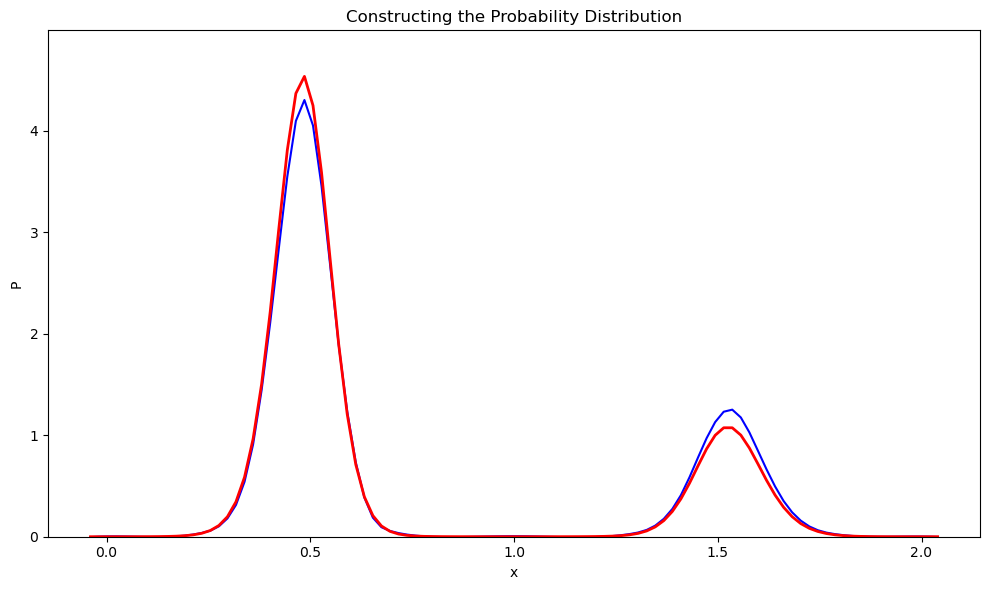

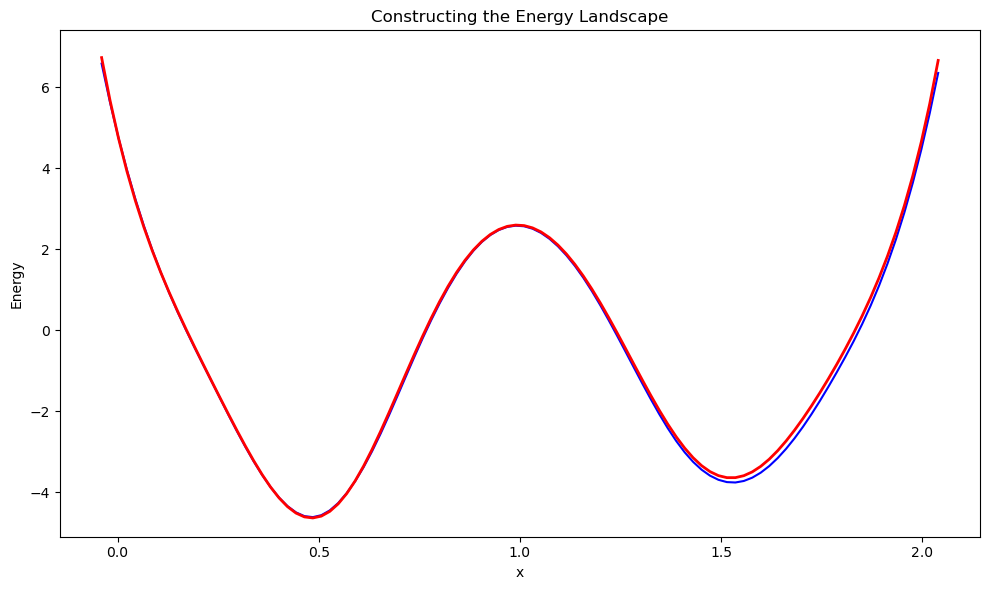

In [ ]:
WHAM_gif(samples, bias, two_well_1d, num_bins=100, max_iters=1000, max_atol=1e-6)

<!-- # Figure Generation -->

## Global Free Energy

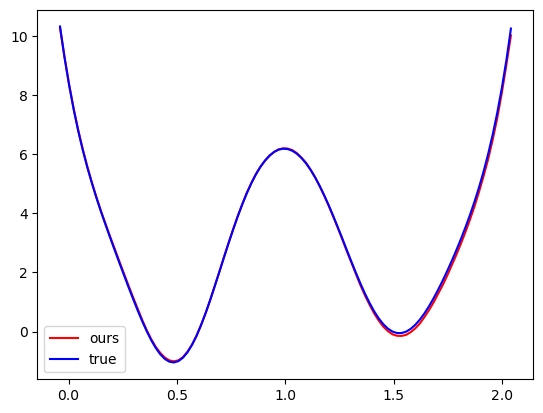

In [18]:
plt.plot(bin_centers, global_free_energy, color='red', label='ours')


recip_V = np.exp(-beta * two_well_1d(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma))
bin_width = (bin_centers[-1] - bin_centers[-2])
norm_recip_V = recip_V/(np.sum(recip_V) * bin_width)
real_free_energy = -1/beta * np.log(norm_recip_V)

plt.plot(bin_centers, real_free_energy, color='blue', label='true')
plt.legend()

## Presentation Plots

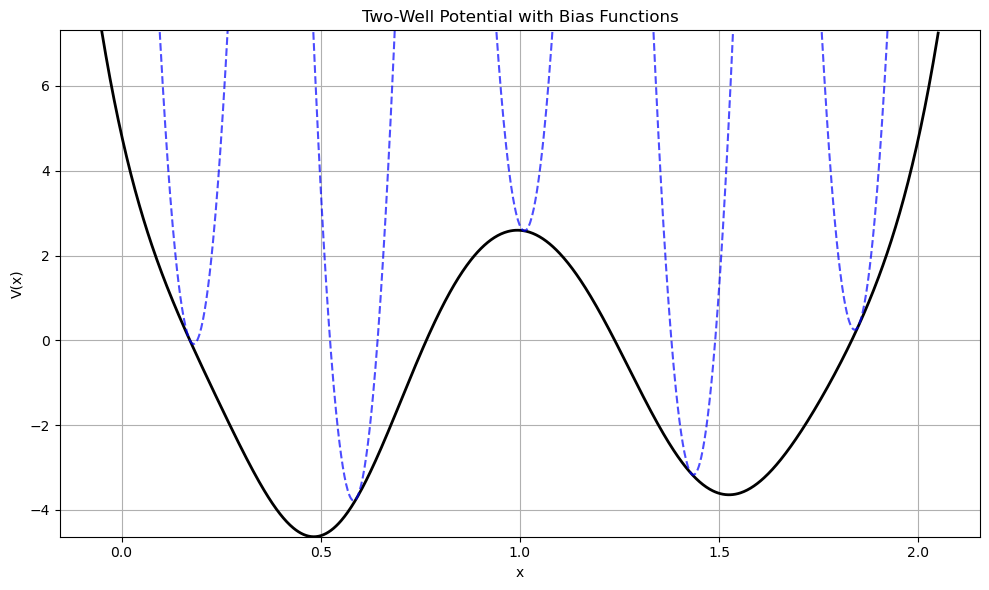

In [19]:
# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Plot the landscape function with bias functions overlaid
plt.figure(figsize=(10, 6))

# Plot the two-well potential function
y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

# Overlay selected bias functions on top of the landscape function
for i in range(10, 100, 20):  # Plot bias functions from different windows
    y_vals_bias = bias[i](x_vals)
    
    # Mask to include only points where y_vals_bias <= 1
    mask = y_vals_bias <= 20
    
    combined_y_vals = y_vals_bias + y_vals_landscape
    plt.plot(x_vals[mask], combined_y_vals[mask], '--', color="blue", label=f'Bias Function {i+1}', alpha=0.7)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Two-Well Potential with Bias Functions')
plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
plt.grid()
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

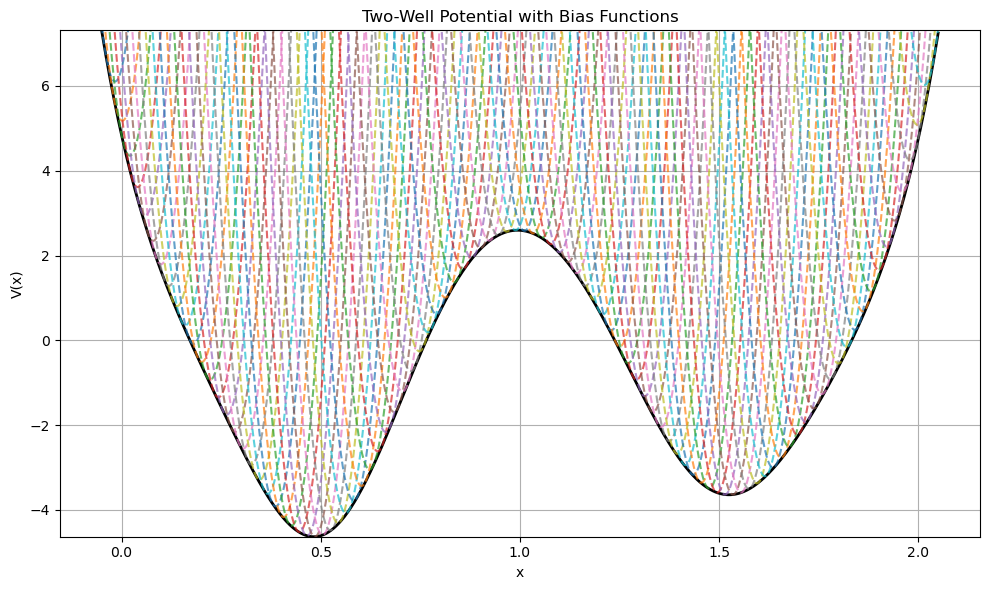

In [20]:
# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Plot the landscape function with bias functions overlaid
plt.figure(figsize=(10, 6))

# Plot the two-well potential function
y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

# Overlay selected bias functions on top of the landscape function
for bias_i in bias:  # Plot bias functions from different windows
    y_vals_bias = bias_i(x_vals)
    
    combined_y_vals = y_vals_bias + y_vals_landscape
    plt.plot(x_vals, combined_y_vals, '--', label=f'Bias Function {i+1}', alpha=0.7)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Two-Well Potential with Bias Functions')
plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
plt.grid()
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

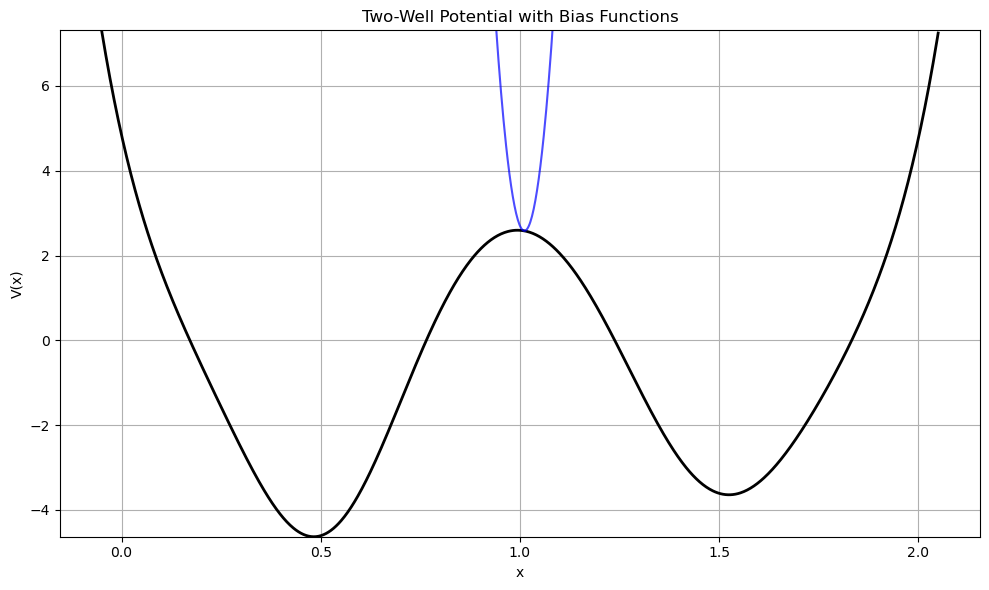

In [21]:
# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Plot the landscape function with bias functions overlaid
plt.figure(figsize=(10, 6))

# Plot the two-well potential function
y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

# Overlay selected bias functions on top of the landscape function
i = len(bias)//2  # Plot bias functions from different windows
y_vals_bias = bias[i](x_vals)

# Mask to include only points where y_vals_bias <= 1
mask = y_vals_bias <= 20

combined_y_vals = y_vals_bias + y_vals_landscape
plt.plot(x_vals[mask], combined_y_vals[mask], color='blue', label=f'Bias Function {i+1}', alpha=0.7)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Two-Well Potential with Bias Functions')
plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
plt.grid()
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

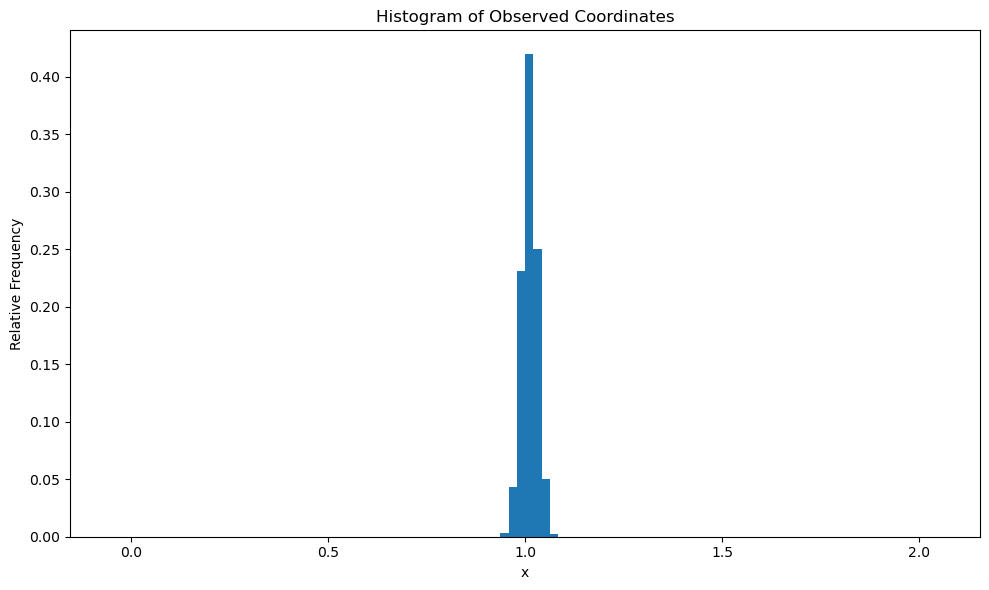

In [22]:
# Calculate bin width
width = bin_edges[1] - bin_edges[0]

hist_norm = hists[i] / np.sum(hists[i])

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(bin_edges[:-1], hist_norm, width=width, align='edge')

# Customize the plot
plt.xlabel('x')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Observed Coordinates')

plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()


In [23]:
# Create a list to store the image frames
frames = []

# Calculate bin width
width = bin_edges[1] - bin_edges[0]

hists_norm = np.array([hists[i] / np.sum(hists[i]) for i in range(len(hists))])

for hist_norm in hists_norm:
    plt.figure(figsize=(10, 6))

    plt.bar(bin_edges[:-1], hist_norm, width=width, align='edge')
    plt.xlabel('x')
    plt.ylabel('Relative Frequency')
    plt.title(f'Histogram of Observed Coordinates')
    plt.ylim((np.min(hists_norm), np.max(hists_norm)))

    plt.gca().set_aspect('auto')
    plt.tight_layout()

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Create an image from the buffer and append to frames
    img = Image.open(buf)
    frames.append(img)

    plt.close()  # Close the figure to free up memory

# Save the frames as an animated GIF
frames[0].save('histogram_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=20, loop=0)


In [24]:
frames = []

# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Loop through bias functions to create frames
for i in range(len(bias)):
    plt.figure(figsize=(10, 6))

    # Plot the two-well potential function
    y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
    plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

    # Overlay selected bias functions on top of the landscape function
    y_vals_bias = bias[i](x_vals)

    # Mask to include only points where y_vals_bias <= 20
    mask = y_vals_bias <= 20
    combined_y_vals = y_vals_bias + y_vals_landscape

    plt.plot(x_vals[mask], combined_y_vals[mask], color='blue', label=f'Bias Function {i+1}', alpha=0.7)

    # Add labels and legend
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title(f'Two-Well Potential with Bias Functions')
    plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
    plt.grid()
    plt.tight_layout()

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Create an image from the buffer and append to frames
    img = Image.open(buf)
    frames.append(img)

    plt.close()  # Close the figure to free up memory

# Save the frames as an animated GIF
frames[0].save('two_well_potential_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=20, loop=0)

# Multi Well

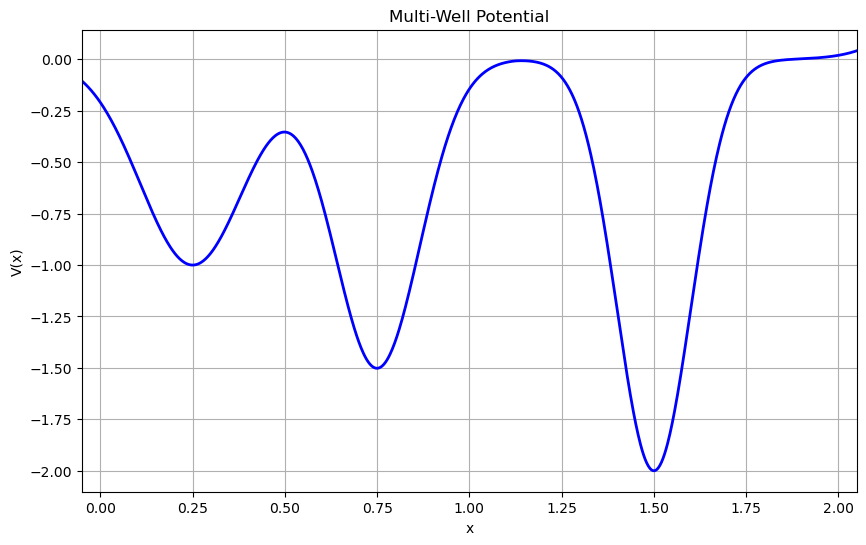

In [25]:
## Parameters for Two Well 1-D Potential

epsilon_0 = 1.0
epsilon_1 = 1.5
epsilon_2 = 2
sigma = 0.2

# Generate x values for the new domain
x = np.linspace(-0.05, 2.05, 1000)

# Calculate potential
V = multi_well_potential(x, epsilon_0, epsilon_1, epsilon_2, sigma)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, V, 'b-', linewidth=2)
plt.title('Multi-Well Potential')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.xlim(-0.05, 2.05)  # Set x-axis limits
plt.grid(True)

plt.show()

In [27]:
samples = np.zeros((Nwindows, nSweeps))
monte_carlo_sampling(bias, multi_well_potential)

(array([0.15770785, 0.17064297, 0.18295824, 0.20147228, 0.2201256 ,
        0.24284224, 0.27428625, 0.31260709, 0.35784875, 0.40539603,
        0.45228715, 0.49328664, 0.52791885, 0.55310092, 0.55865736,
        0.54564341, 0.51966914, 0.47635713, 0.4315925 , 0.38799329,
        0.34893762, 0.31097897, 0.28028785, 0.25047528, 0.23607832,
        0.22601689, 0.22531071, 0.23092024, 0.25089468, 0.28351073,
        0.3347876 , 0.40684056, 0.50455868, 0.62261229, 0.77367978,
        0.94179505, 1.07517051, 1.16319533, 1.17203756, 1.10698557,
        0.96770491, 0.79027862, 0.63488978, 0.50661297, 0.40048968,
        0.32259574, 0.25980314, 0.21985628, 0.19668282, 0.17739622,
        0.1626435 , 0.15118516, 0.14863927, 0.1426188 , 0.13967198,
        0.13794687, 0.13828606, 0.13751172, 0.13835286, 0.14190618,
        0.14481443, 0.1521585 , 0.16275288, 0.17932281, 0.20516225,
        0.25010942, 0.32840925, 0.4508444 , 0.64320649, 0.93319079,
        1.33887868, 1.80475905, 2.26440493, 2.43

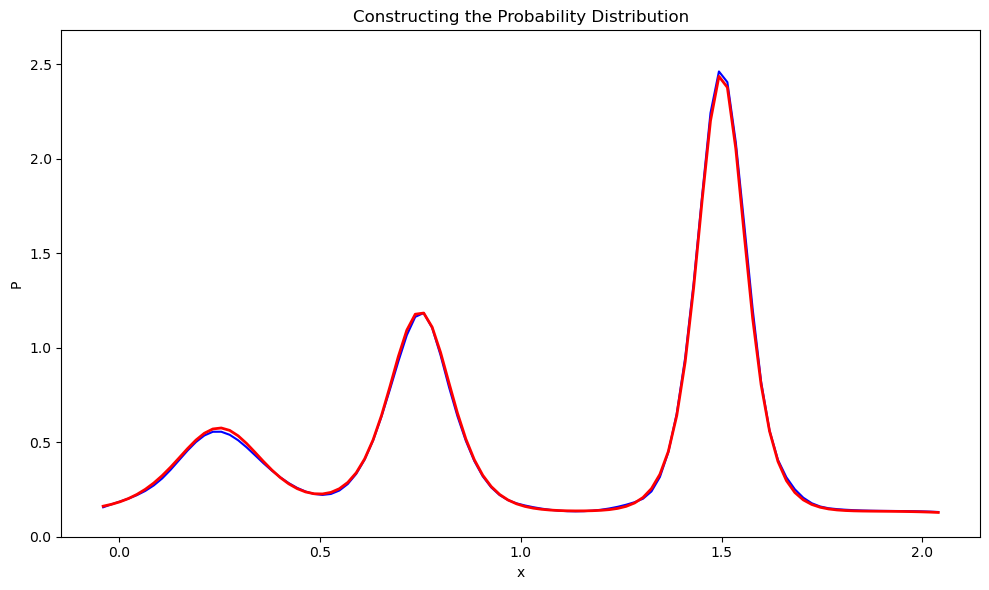

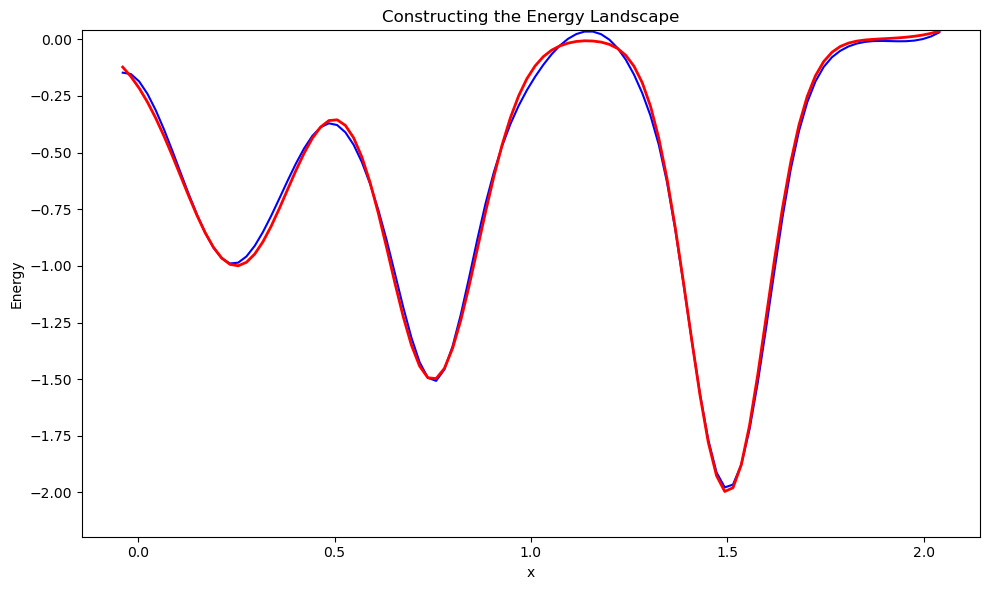

In [32]:
WHAM_gif(samples, bias, multi_well_potential, num_bins=100, max_iters=1000, max_atol=1e-6, prefix="multi_well_")